# Impact of Abortion Opinion on 2022 Midterms

## Leah Schneck (lmschneck@wisc.edu)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas_datareader.data as web
import matplotlib.dates as mdates
from pandas_datareader import data, wb
import geopandas  
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression

## Importing and Cleaning Data

In [2]:
states = geopandas.read_file('cb_2021_us_state_5m.zip')
states.rename(columns={'NAME': 'state'}, inplace=True)

In [3]:
abortion = pd.read_excel('project_data.xlsx', sheet_name = 'abortion')
legality = pd.read_excel('project_data.xlsx', sheet_name = 'legality')
house = pd.read_excel('project_data.xlsx', sheet_name = 'house')

In [4]:
# merging the data into one dataframe and excluding AK and HI for ease of graphing purposes
data = pd.merge(abortion, legality, how='left', on=['id', 'state'])
data = pd.merge(data, house, how='left', on=['id', 'state'])
continental_data = data[(data['id'] != 'AK')&(data['id'] != 'HI')].reset_index(drop=True)

In [5]:
# cleaning the dataframe and determining states with positive seat changes
continental_data = continental_data.replace('-', 0)
continental_data['rep_change'] = continental_data['rep_change'].dropna().astype(int)
continental_data['dem_change'] = continental_data['dem_change'].dropna().astype(int)
rep_pos = continental_data[continental_data['rep_change'] > 0]
dem_pos = continental_data[continental_data['dem_change'] > 0]
rep_pos.set_index('id', inplace=True)
dem_pos.set_index('id', inplace=True)

## Preliminary Graphs and Observations

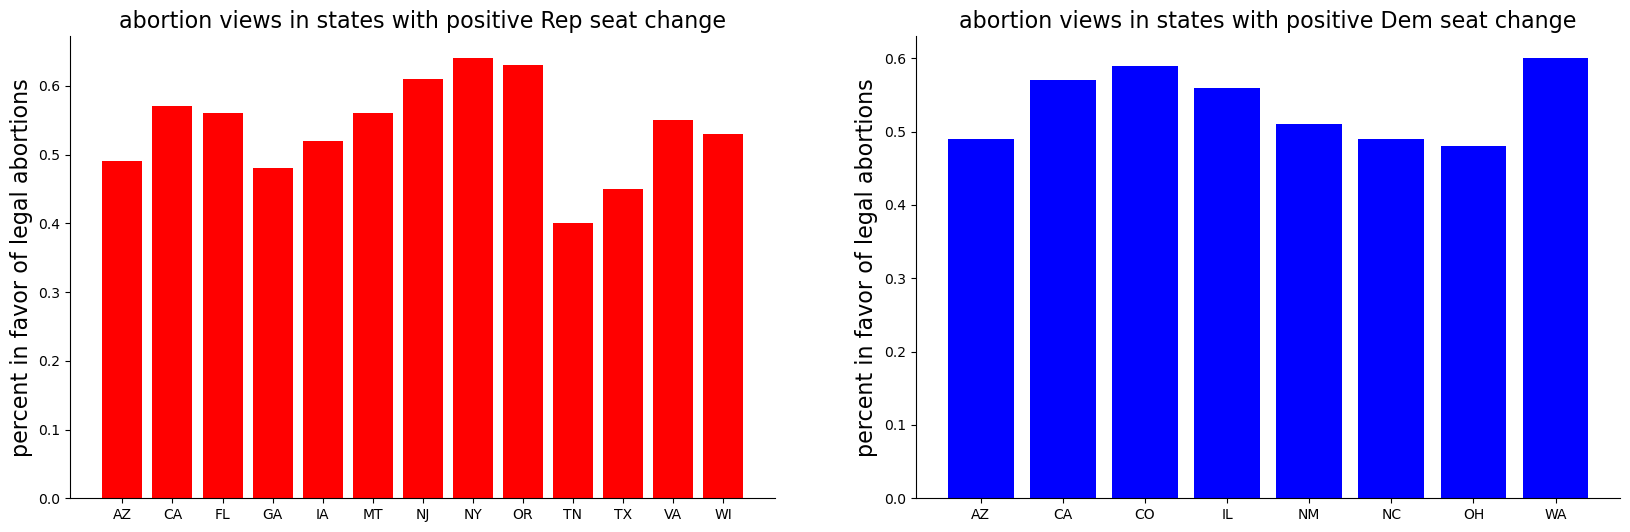

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].bar(rep_pos.index, rep_pos['legal'], color='red')
ax[1].bar(dem_pos.index, dem_pos['legal'], color='blue')
ax[0].set_ylabel('percent in favor of legal abortions', fontsize = 16)
ax[1].set_ylabel('percent in favor of legal abortions', fontsize = 16)
ax[0].set_title('abortion views in states with positive Rep seat change', fontsize = 16)
ax[1].set_title('abortion views in states with positive Dem seat change', fontsize = 16)

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
plt.savefig('graph1.svg', format='svg')
plt.show()

/Users/leahschneck/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


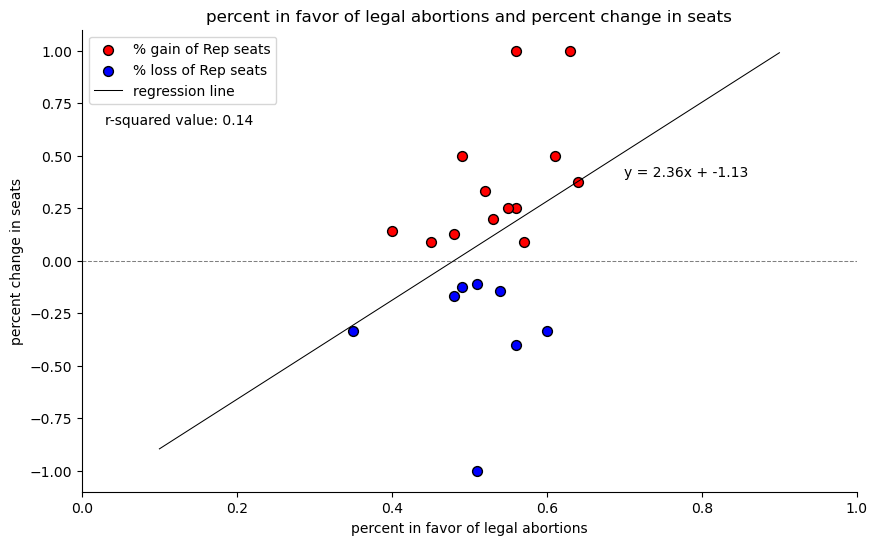

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

# splitting data for the purpose of coloring data points red or blue
rep_x = continental_data[(continental_data['rep_percent_change'] > 0)]['legal']
rep_y = continental_data[(continental_data['rep_percent_change'] > 0)]['rep_percent_change']
dem_x = continental_data[(continental_data['rep_percent_change'] < 0)]['legal']
dem_y = continental_data[(continental_data['rep_percent_change'] < 0)]['rep_percent_change']

# sklearn code from my machine learning class
x = pd.DataFrame(continental_data[(continental_data['rep_percent_change'] != 0)]['legal'])
y = continental_data[(continental_data['rep_percent_change'] != 0)]['rep_percent_change']
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0]
intercept = model.intercept_
r2 = 'r-squared value: ' + str(round(model.score(x, y), 2))
# creating a regression line that spans the entire graph
x = pd.DataFrame([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
regression_line = model.predict(x)
formula = 'y = ' + str(round(slope, 2)) + 'x + ' + str(round(intercept, 2))

plt.scatter(rep_x, rep_y, color='red', edgecolor='black', s=50, label='% gain of Rep seats')
plt.scatter(dem_x, dem_y, color='blue', edgecolor='black', s=50, label='% loss of Rep seats')
ax.axhline(y=0, color='gray', linewidth=0.75, linestyle='--')
plt.plot(x, regression_line, color='black', linewidth=0.75, label='regression line')

plt.xlim(0, 1)
ax.set_title('percent in favor of legal abortions and percent change in seats')
ax.set_xlabel('percent in favor of legal abortions')
ax.set_ylabel('percent change in seats')
ax.text(0.7, 0.4, formula) 
ax.text(0.03, 0.65, r2) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.savefig('graph2.svg', format='svg')
plt.show()

## Breaking Down the Data by State

In [8]:
# cleaning the geodataframe and adding columns for graphing purposes
continental = states[states['state'].isin(list(continental_data['state']))]
continental = continental.sort_values(by='state').reset_index(drop=True)
continental['law'] = continental_data['law']
continental['legal'] = continental_data['legal']
continental['rep_percent_change'] = continental_data['rep_percent_change']
continental['prev_rep_percent_change'] = continental_data['prev_rep_percent_change']

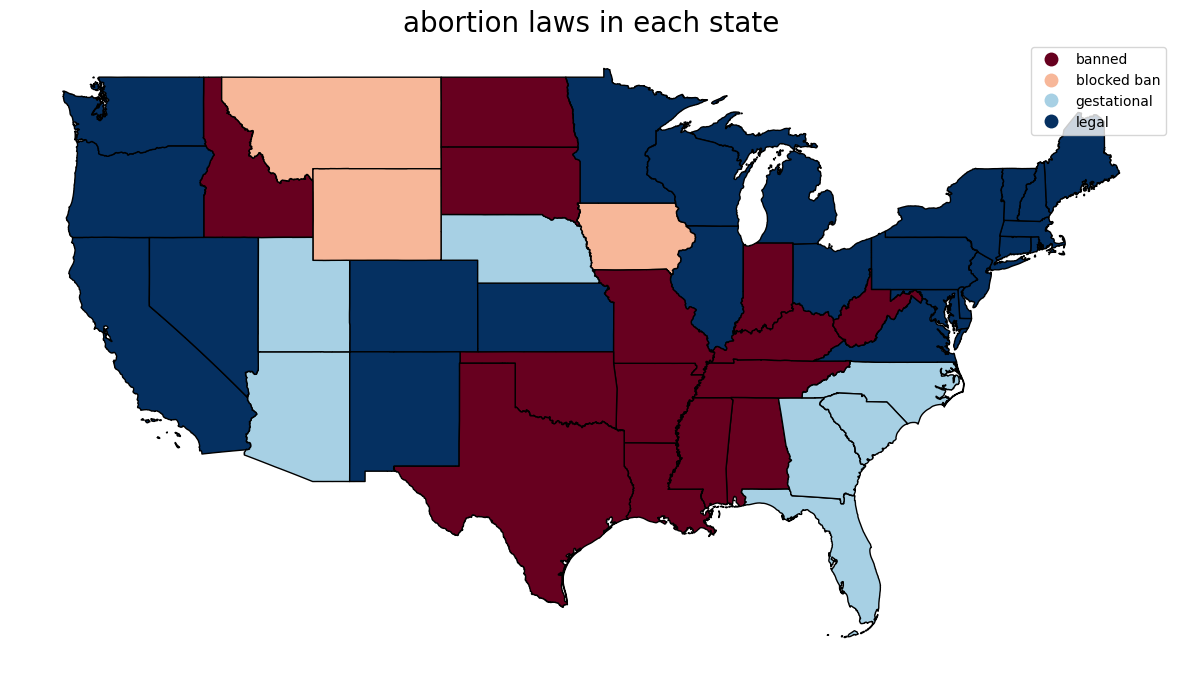

In [9]:
fig, gax = plt.subplots(figsize=(15,10))

continental.plot(ax=gax, edgecolor='black', column='law', cmap='RdBu', legend=True)

gax.axis('off')
gax.set_title('abortion laws in each state', fontsize=20)
plt.savefig('graph3.svg', format='svg')
plt.show()

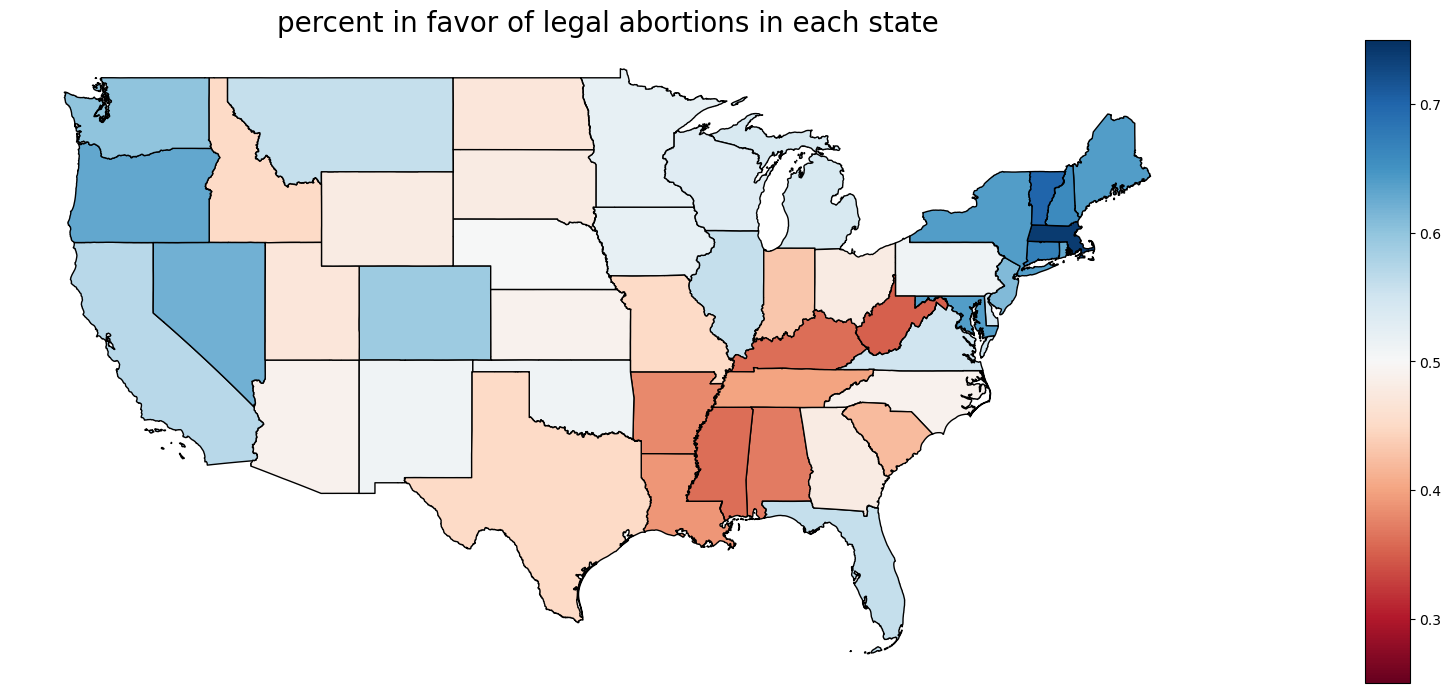

In [10]:
fig, gax = plt.subplots(figsize=(20,15))

divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='3%', pad=0.1)
continental.plot(ax=gax, edgecolor='black', column='legal', cmap='RdBu',
                 vmin=0.25, vmax=0.75, legend=True, cax=legend_ax)

gax.axis('off')
gax.set_title('percent in favor of legal abortions in each state', fontsize=20)
plt.savefig('graph4.svg', format='svg')
plt.show()

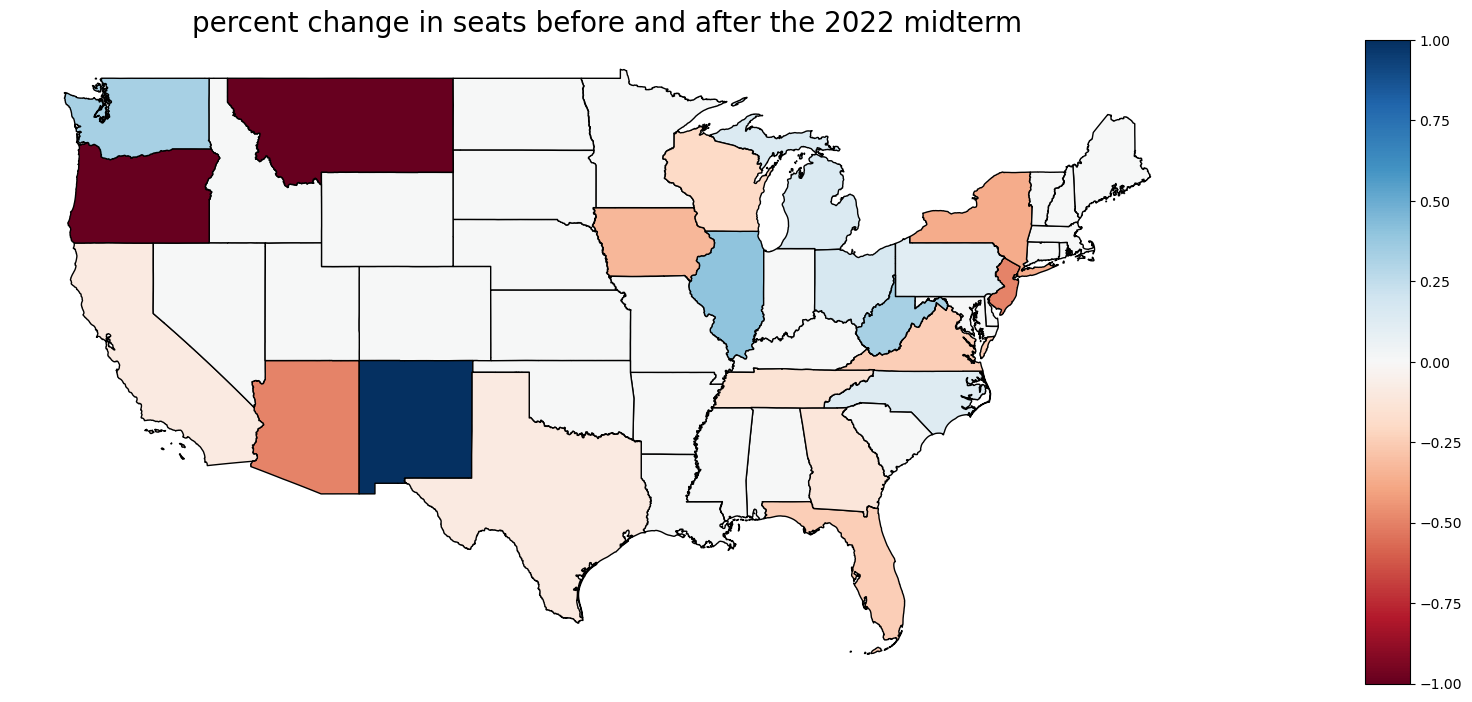

In [11]:
fig, gax = plt.subplots(figsize=(20,15))

divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='3%', pad=0.1)
# multiplying by -1 for contextual reasons with the RdBu colormap
continental['mod_rep_percent_change'] = continental['rep_percent_change'] * (-1)
continental.plot(ax=gax, edgecolor='black', column='mod_rep_percent_change', cmap='RdBu',
                 vmin=-1, vmax=1, legend=True, cax=legend_ax)

gax.axis('off')
gax.set_title('percent change in seats before and after the 2022 midterm', fontsize=20)
plt.savefig('graph5.svg', format='svg')
plt.show()

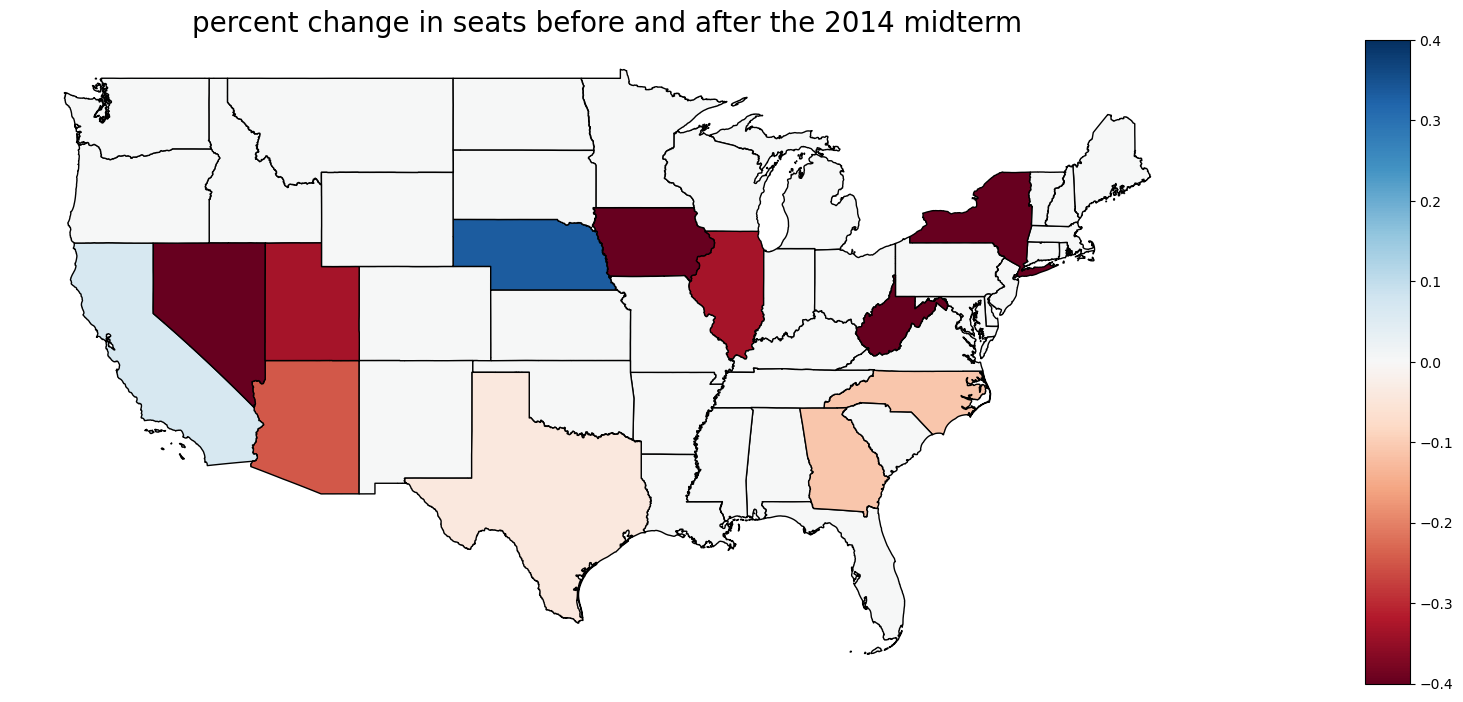

In [12]:
fig, gax = plt.subplots(figsize=(20,15))

divider = make_axes_locatable(gax)
legend_ax = divider.append_axes('right', size='3%', pad=0.1)
# multiplying by -1 for contextual reasons with the RdBu colormap
continental['mod_prev_rep_percent_change'] = continental['prev_rep_percent_change'] * (-1)
continental.plot(ax=gax, edgecolor='black', column='mod_prev_rep_percent_change', cmap='RdBu',
                 vmin=-0.4, vmax=0.4, legend=True, cax=legend_ax)

gax.axis('off')
gax.set_title('percent change in seats before and after the 2014 midterm', fontsize=20)
plt.savefig('graph6.svg', format='svg')
plt.show()